# Simulation eines Abstandssensors mit linearer Kennlinie

## Erzeugen von Zufallszahlen

In [1]:
import numpy

In [2]:
numpy.random.normal(loc=0, scale=1.0)

1.7451417542134018

In [3]:
A = numpy.random.normal(loc=3, scale=1.0, size=(10000))
A[:5]

array([2.10162772, 3.54874302, 2.23165761, 3.71090895, 2.96244879])

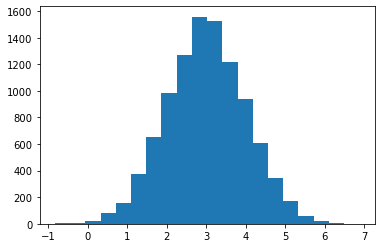

In [4]:
import matplotlib.pyplot as plt
plt.hist(A, bins=20)
plt.show()

## Eine Sensorklasse

In [5]:
class sensor_lineare_kennlinie:
    
    def __init__(self, bias, noise):
        self.bias = bias
        self.noise = noise
        
    def get_sensorwert(self, x):        
        sensorwert = x + numpy.random.normal(loc=self.bias, scale=self.noise)
        return sensorwert
    
    def zeige_sensor_kurve(self):
        gw = []
        sensorwerte = []
        for x in range(0,101):
            sensorwert = self.get_sensorwert(x)
            gw.append(x)
            sensorwerte.append(sensorwert)
        plt.plot(gw,sensorwerte)
        plt.xlabel("gw (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show()        

In [6]:
s1 = sensor_lineare_kennlinie(-20.0, 1.0)

In [7]:
s1.get_sensorwert(100)

79.4048405476637

In [8]:
s2 = sensor_lineare_kennlinie(-5, 3.0)
s2.get_sensorwert(100)

94.62488135307724

## Sensorkurven

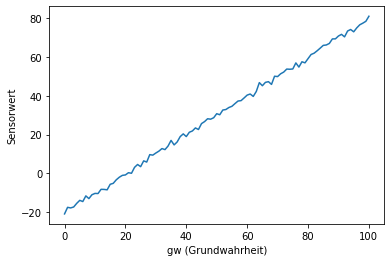

In [9]:
s1.zeige_sensor_kurve()

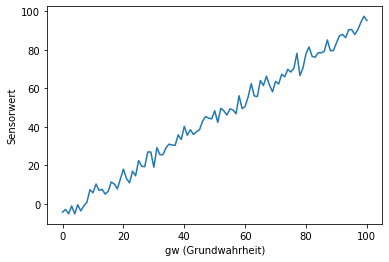

In [10]:
s2.zeige_sensor_kurve()

# Erste Fusionsansätze

## Fehlerfunktion für Fusionsergebnisse

In [11]:
gw = numpy.array([1,2,3,4,5])
sensorwerte = numpy.array([1.1, 2.2, 2.9, 4.05, 5.9])

In [12]:
numpy.mean(abs(gw - sensorwerte))

0.27000000000000013

In [13]:
def MAE(gw, sensorwerte):
    MAE = numpy.mean(abs(gw - sensorwerte))
    return MAE

In [14]:
MAE(gw, sensorwerte)

0.27000000000000013

## Auswertung für Sensor 1

In [15]:
def erzeuge_messreihe(s, N):
    gw = []
    sensorwerte = []
    for x in range(0,N):
        sensorwert = s.get_sensorwert(x)
        gw.append(x)
        sensorwerte.append(sensorwert)
        
    return numpy.array(gw), numpy.array(sensorwerte)

In [16]:
gw, sensorwerte1 = erzeuge_messreihe(s1,1000)
MAE(gw, sensorwerte1)

20.054058057674066

In [17]:
gw[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
sensorwerte1[:10]

array([-19.17533259, -19.06297536, -19.27737302, -18.25536015,
       -13.55716047, -14.63597773, -12.08696648, -14.51049408,
       -14.77476595, -10.95219075])

## Auswertung für Sensor 2

In [19]:
gw, sensorwerte2 = erzeuge_messreihe(s2, 1000)
MAE(gw, sensorwerte2)

5.190375731748889

In [20]:
gw[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
sensorwerte2[:10]

array([ 1.31447273, -0.57406717,  1.66890143, -8.06072704, -6.26397476,
       -6.82272227,  3.34445472,  0.79525333,  7.27823252,  4.6992888 ])

## Sensorfusion über einfache Mittelwertbildung bringt es nicht!

In [22]:
sensorwerte1[:10]

array([-19.17533259, -19.06297536, -19.27737302, -18.25536015,
       -13.55716047, -14.63597773, -12.08696648, -14.51049408,
       -14.77476595, -10.95219075])

In [23]:
sensorwerte2[:10]

array([ 1.31447273, -0.57406717,  1.66890143, -8.06072704, -6.26397476,
       -6.82272227,  3.34445472,  0.79525333,  7.27823252,  4.6992888 ])

In [24]:
sensorwerte3 = (sensorwerte1+sensorwerte2)/2
sensorwerte3[:10]

array([ -8.93042993,  -9.81852126,  -8.8042358 , -13.15804359,
        -9.91056762, -10.72935   ,  -4.37125588,  -6.85762037,
        -3.74826672,  -3.12645098])

In [25]:
MAE(gw, sensorwerte3)

12.563491367522026

## Sensorfusion mit Biaskorrektur

In [26]:
def ME(gw, sensorwerte):
    ME = numpy.mean(gw - sensorwerte)
    return ME

In [27]:
bias1 = ME(gw,sensorwerte1)
bias1

20.054058057674066

In [28]:
bias2 = ME(gw,sensorwerte2)
bias2

5.072924677369989

In [29]:
sensorwerte1[:5]

array([-19.17533259, -19.06297536, -19.27737302, -18.25536015,
       -13.55716047])

In [30]:
(sensorwerte1+bias1)[:5]

array([0.87872547, 0.9910827 , 0.77668504, 1.79869791, 6.49689759])

In [31]:
sensorwerte4 = ((sensorwerte1+bias1) + (sensorwerte2+bias2))/2

In [32]:
MAE(gw,sensorwerte4)

1.2530417509329164

# Simulation eines Abstandssensors mit nicht-linearer Kennlinie

## Der Logarithmus ist eine nicht-lineare Funktion

In [33]:
x = numpy.arange(1,1001)
x[:100]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [34]:
y = numpy.log(x)
y[:100]

array([0.        , 0.69314718, 1.09861229, 1.38629436, 1.60943791,
       1.79175947, 1.94591015, 2.07944154, 2.19722458, 2.30258509,
       2.39789527, 2.48490665, 2.56494936, 2.63905733, 2.7080502 ,
       2.77258872, 2.83321334, 2.89037176, 2.94443898, 2.99573227,
       3.04452244, 3.09104245, 3.13549422, 3.17805383, 3.21887582,
       3.25809654, 3.29583687, 3.33220451, 3.36729583, 3.40119738,
       3.4339872 , 3.4657359 , 3.49650756, 3.52636052, 3.55534806,
       3.58351894, 3.61091791, 3.63758616, 3.66356165, 3.68887945,
       3.71357207, 3.73766962, 3.76120012, 3.78418963, 3.80666249,
       3.8286414 , 3.8501476 , 3.87120101, 3.8918203 , 3.91202301,
       3.93182563, 3.95124372, 3.97029191, 3.98898405, 4.00733319,
       4.02535169, 4.04305127, 4.06044301, 4.07753744, 4.09434456,
       4.11087386, 4.12713439, 4.14313473, 4.15888308, 4.17438727,
       4.18965474, 4.20469262, 4.21950771, 4.2341065 , 4.24849524,
       4.26267988, 4.27666612, 4.29045944, 4.30406509, 4.31748

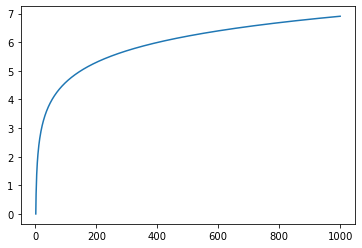

In [35]:
#plt.scatter(x,y, marker="+")
plt.plot(x,y)
plt.show()

## Eine neue Sensor-Klasse

In [36]:
class sensor_nichtlineare_kennlinie:
    
    def __init__(self, bias, noise):
        self.bias = bias
        self.noise = noise
        
    def get_sensorwert(self, x):        
        sensorwert = x + numpy.random.normal(loc=self.bias, scale=self.noise) + 500*numpy.log(1+x)
        return sensorwert
    
    def zeige_sensor_kurve(self):
        gw = []
        sensorwerte = []
        for x in range(0,1001):
            sensorwert = self.get_sensorwert(x)
            gw.append(x)
            sensorwerte.append(sensorwert)
        plt.plot(gw,sensorwerte)
        plt.xlabel("gw (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show()   

In [37]:
s5 = sensor_nichtlineare_kennlinie(50,20)

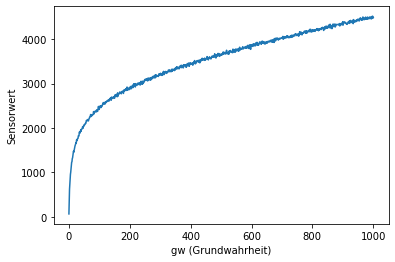

In [38]:
s5.zeige_sensor_kurve()

In [39]:
s6 = sensor_nichtlineare_kennlinie(-100,80)

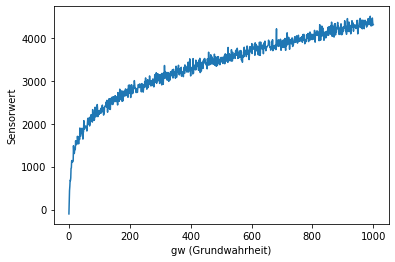

In [40]:
s6.zeige_sensor_kurve()

# Neuer Fusionsansatz

## Inverses Sensormodell (ISM)

In [41]:
gw = []
mittlere_sensorwerte = []

ism_s6 = {}

for x in range(0,1001):    
    sensorwerte = []
    for run in range(0,50):
        sensorwert = s6.get_sensorwert(x)
        sensorwerte.append( sensorwert )
    mittlerer_sensorwert = numpy.mean(sensorwerte)
    
    gw.append(x)
    mittlere_sensorwerte.append( mittlerer_sensorwert )
    
    ism_s6[mittlerer_sensorwert] = x

In [42]:
gw[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [43]:
mittlere_sensorwerte[:10]

[-107.03424853386315,
 257.43818900565907,
 471.2700940657882,
 607.4991693604392,
 715.3009172507088,
 791.2481902058499,
 910.3979277528838,
 952.480931215511,
 1015.3702618630637,
 1063.156284328503]

In [44]:
list( ism_s6.items() ) [:10]

[(-107.03424853386315, 0),
 (257.43818900565907, 1),
 (471.2700940657882, 2),
 (607.4991693604392, 3),
 (715.3009172507088, 4),
 (791.2481902058499, 5),
 (910.3979277528838, 6),
 (952.480931215511, 7),
 (1015.3702618630637, 8),
 (1063.156284328503, 9)]

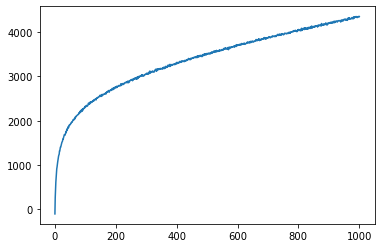

In [45]:
plt.plot(gw, mittlere_sensorwerte)
plt.show()

In [46]:
class ism:
    
    def __init__(self, s):
        self.sensor = s
        
    def baue_lut_auf(self):        
        self.lut = {}
        for x in range(0,1001):
            sensorwerte = []
            for run in range(0,50):
                sensorwert = self.sensor.get_sensorwert(x)
                sensorwerte.append( sensorwert )
            mittlerer_sensorwert = numpy.mean(sensorwerte)
            self.lut[mittlerer_sensorwert] = x
            
    def sensorwert_zu_entfernung(self, sensorwert):
        min_dist = None
        best_key = None
        for key in self.lut:
            dist = abs(sensorwert - key)
            if best_key==None or dist < min_dist:
                best_key = key
                min_dist = dist
        
        beste_entfernungs_schaetzung = self.lut[best_key]
        return beste_entfernungs_schaetzung

In [47]:
ism_s6 = ism(s6)
ism_s6.baue_lut_auf()

In [48]:
sensorwert = -102
min_dist = None
best_key = None
for key in ism_s6.lut:
    dist = abs(sensorwert - key)
    if best_key==None or dist < min_dist:
        best_key = key
        min_dist = dist

In [49]:
best_key

-106.06573077363912

In [50]:
ism_s6.lut[best_key]

0

In [51]:
ism_s6.sensorwert_zu_entfernung( sensorwert )

0

## Sensordatenfusion über inverse Sensormodelle

In [52]:
s5 = sensor_nichtlineare_kennlinie(50,5)
s6 = sensor_nichtlineare_kennlinie(-100,20)

ism_s5 = ism(s5)
ism_s5.baue_lut_auf()

ism_s6 = ism(s6)
ism_s6.baue_lut_auf()

In [53]:
gw = []
sensorwerte_s5 = []
sensorwerte_s6 = []
fusions_ergebnisse = []

for x in range(0,1001):
    sensorwert5 = s5.get_sensorwert(x)
    sensorwert6 = s6.get_sensorwert(x)

    e5 = ism_s5.sensorwert_zu_entfernung(sensorwert5)
    e6 = ism_s6.sensorwert_zu_entfernung(sensorwert6)

    fusionierte_finale_entfernungs_schaetzung = (e5+e6) / 2
    
    gw.append(x)
    sensorwerte_s5.append(sensorwert5)
    sensorwerte_s6.append(sensorwert6)
    fusions_ergebnisse.append(fusionierte_finale_entfernungs_schaetzung)

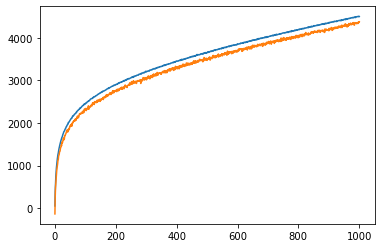

In [54]:
plt.plot(gw, sensorwerte_s5)
plt.plot(gw, sensorwerte_s6)
plt.show()

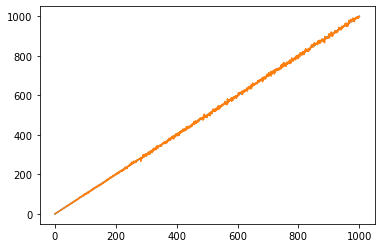

In [55]:
plt.plot(gw, gw)
plt.plot(gw, fusions_ergebnisse)
plt.show()

# Simulation eines echt fiesen Abstandssensors

## Seltsame Kennlinie erzeugen

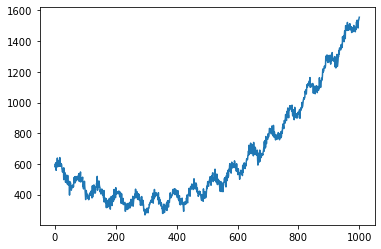

In [56]:
bias = -50
noise = 20
pos = 500

gw = []
sensorwerte = []
for x in range(0,1001):
    sensorwert = x + 50*numpy.sin(x/10) + numpy.random.normal(loc=bias, scale=noise) + ((x-pos)/20)**2
    
    gw.append(x)
    sensorwerte.append(sensorwert)
    
plt.plot(gw,sensorwerte)
plt.show()

## Neue Sensorklasse

In [57]:
class sensor_strange:
    
    def __init__(self, bias, noise, pos):
        self.bias = bias
        self.noise = noise
        self.pos = pos
        
    def get_sensorwert(self, x):        
        sensorwert = x + 50*numpy.sin(x/10) + numpy.random.normal(loc=bias, scale=noise) + ((x-self.pos)/20)**2
        return sensorwert
    
    def zeige_sensor_kurve(self):
        gw = []
        sensorwerte = []
        for x in range(0,1001):
            sensorwert = self.get_sensorwert(x)
            gw.append(x)
            sensorwerte.append(sensorwert)
        plt.plot(gw,sensorwerte)
        plt.xlabel("gw (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show() 

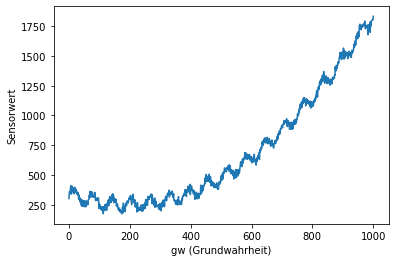

In [58]:
s7 = sensor_strange(-50,20,400)
s7.zeige_sensor_kurve()

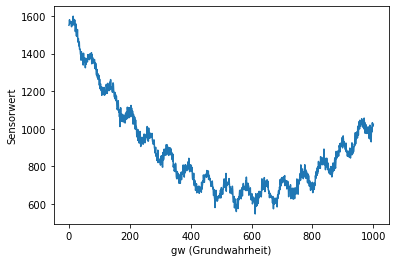

In [59]:
s8 = sensor_strange(-50,20,800)
s8.zeige_sensor_kurve()

# Eine lernende Sensordatenfusion

## Einleitung: Wieso Machine Learning?

Problem / Herausforderung: wir müssen nun damit umgehen, dass ein "einfaches" Inverses Sensormodell (ISM) nicht mehr möglich ist.

Der Messwert "300" bei Sensor 7 kann nämlich bei mehreren verschiedenen Distanzen vorkommen.

Aber wir haben ja auch noch den Sensor 8, der gleichzeitig auch einen Sensorwert liefert. Dieser Sensorwert kann als weitere Hilfsquelle zur Auflösung von Mehrdeutigkeiten verwendet werden.

Wir lernen dazu über "Machine Learning" ein Inverses Sensor Modell, das einen Messvektor **z** auf einen Zustandsvektor **x** abbildet.

## Vorbereiten der Beispieldaten fürs Machine Learning

In [60]:
X = numpy.zeros( (1000,2) )
Y = numpy.zeros( (1000,1) )

i = 0
for e in range(0,1000):
    sensorwert_s7 = s7.get_sensorwert(e)
    sensorwert_s8 = s8.get_sensorwert(e)
    
    X[i,:] = numpy.array( [sensorwert_s7, sensorwert_s8] )
    Y[i,0] = e
    
    i += 1

In [61]:
X.shape

(1000, 2)

In [62]:
Y.shape

(1000, 1)

In [63]:
X[0:5]

array([[ 354.20327482, 1533.27609876],
       [ 360.30053605, 1570.41441201],
       [ 364.59737287, 1558.08582307],
       [ 346.77111146, 1549.57737087],
       [ 385.36355817, 1582.98400051]])

In [64]:
Y[0:5]

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.]])

## Beispieldaten aufspalten in Trainings- und Testdaten

In [65]:
# Aufspaltung in Trainings- und Testdaten
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [66]:
x_train.shape

(800, 2)

In [67]:
x_train[0:5]

array([[ 805.06514695,  638.21360415],
       [ 465.8724507 ,  660.55491498],
       [ 353.47842985,  850.54467824],
       [1731.30495657,  993.23122069],
       [1193.3121527 ,  756.57810869]])

In [68]:
y_train[0:5]

array([[687.],
       [500.],
       [332.],
       [979.],
       [817.]])

In [69]:
x_test.shape

(200, 2)

In [70]:
y_test.shape

(200, 1)

## Machine Learning mittels scikit-learn

In [71]:
# k-NN Regressor erlernen
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
knn = knn.fit(x_train, y_train)

## Testen der Modellgüte

In [72]:
y_pred_test = knn.predict( x_test )

In [73]:
y_pred_test[0:5]

array([[989.66666667],
       [859.66666667],
       [300.33333333],
       [548.66666667],
       [676.33333333]])

In [74]:
y_test[0:5]

array([[993.],
       [859.],
       [298.],
       [553.],
       [672.]])

In [75]:
y_pred_test.shape

(200, 1)

In [76]:
y_test.shape

(200, 1)

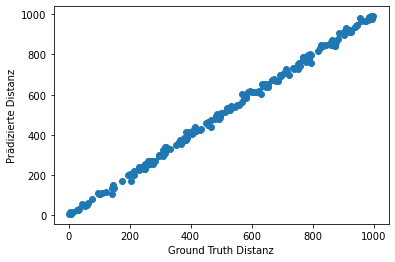

In [77]:
plt.scatter(y_test.flatten(), y_pred_test.flatten())
plt.xlabel("Ground Truth Distanz")
plt.ylabel("Prädizierte Distanz")
plt.show()

In [78]:
MAE( y_test.flatten(), y_pred_test.flatten() )

8.87666666666667

# Lernende Ansätze zur Fusion von Sensordaten unterschiedlicher Ranges

## Eine neue Sensorklasse

In [79]:
class sensor_strange_range:
    
    def __init__(self, bias, noise, pos, fac):
        self.bias = bias
        self.noise = noise
        self.pos = pos
        self.fac = fac
        
    def get_sensorwert(self, x):        
        sensorwert = self.fac * (x + 50*numpy.sin(x/10) + numpy.random.normal(loc=bias, scale=noise) + ((x-self.pos)/20)**2)
        return sensorwert
    
    def zeige_sensor_kurve(self):
        gw = []
        sensorwerte = []
        for x in range(0,1001):
            sensorwert = self.get_sensorwert(x)
            gw.append(x)
            sensorwerte.append(sensorwert)
        plt.plot(gw,sensorwerte)
        plt.xlabel("gw (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show() 

In [80]:
s9  = sensor_strange_range(-50,20,400, 1)
s10 = sensor_strange_range(-50,20,800, 100)

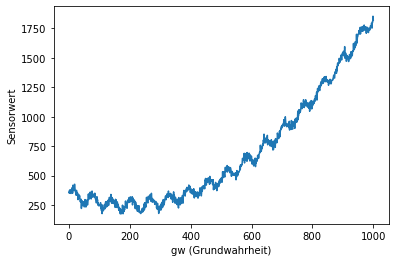

In [81]:
s9.zeige_sensor_kurve()

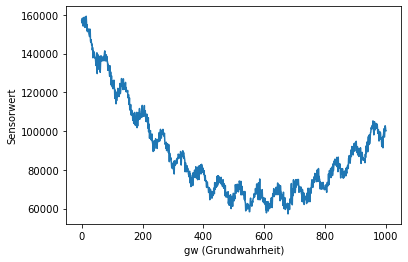

In [82]:
s10.zeige_sensor_kurve()

## Machine Learning Reloaded

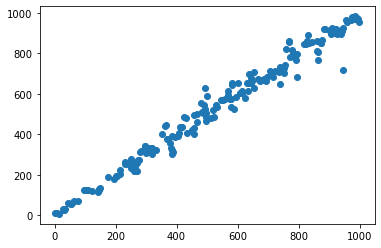

MAE= 25.998333333333335


In [83]:
# 1. Beispieldaten fürs ML vorbereiten
X = numpy.zeros( (1000,2) )
Y = numpy.zeros( (1000,1) )
i = 0
for e in range(0,1000):
    sensorwert_s9  = s9.get_sensorwert(e)
    sensorwert_s10 = s10.get_sensorwert(e)    
    X[i,:] = numpy.array( [sensorwert_s9, sensorwert_s10] )
    Y[i,0] = e    
    i += 1


# 2. Beispieldaten in Trainings- und Testdaten aufteilen
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


# 3. k-NN Regressor erlernen
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
knn = knn.fit(x_train, y_train)


# 4. Modellgüte ermitteln
y_pred_test = knn.predict( x_test )


# 5. Plotten der Prädiktionen
plt.scatter(y_test.flatten(), y_pred_test.flatten())
plt.show()


# 6. Quantitative Auswertung des mittleren Fehlers
print( "MAE=", MAE( y_test.flatten(), y_pred_test.flatten() ) )

Man sieht, dass der Fehler deutlich größer geworden ist! Der Grund ist, dass der k-NN Regressor nun nicht mehr mit dem Standardabstandsmaß (euklidische Maß) funktioniert. Wir müssen dazu vorher die Sensormesswerte normalisieren!

## Normalisierung

In [84]:
D = numpy.array( [[-20,-2],
                  [-10,-1],
                  [  0, 0],
                  [+10,+1],
                  [+20,+2]] )

In [85]:
D

array([[-20,  -2],
       [-10,  -1],
       [  0,   0],
       [ 10,   1],
       [ 20,   2]])

In [86]:
numpy.mean( D[:,0] )

0.0

In [87]:
numpy.std( D[:,0] )

14.142135623730951

In [88]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
D_scaled = scaler.fit_transform(D)

In [89]:
D_scaled

array([[-1.41421356, -1.41421356],
       [-0.70710678, -0.70710678],
       [ 0.        ,  0.        ],
       [ 0.70710678,  0.70710678],
       [ 1.41421356,  1.41421356]])

In [90]:
D_scaled[:,0]

array([-1.41421356, -0.70710678,  0.        ,  0.70710678,  1.41421356])

In [91]:
numpy.mean( D_scaled[:,0] )

0.0

In [92]:
numpy.std( D_scaled[:,0] )

0.9999999999999999

## Jetzt ML mit Skalierung der Sensordaten

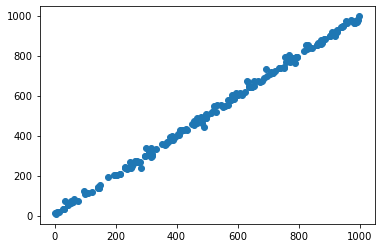

MAE = 9.01cm


In [93]:
# 1. Beispieldaten fürs ML vorbereiten
X = numpy.zeros( (1000,2) )
Y = numpy.zeros( (1000,1) )
i = 0
for e in range(0,1000):
    sensorwert_s9  = s9.get_sensorwert(e)
    sensorwert_s10 = s10.get_sensorwert(e)    
    X[i,:] = numpy.array( [sensorwert_s9, sensorwert_s10] )
    Y[i,0] = e    
    i += 1


# 2. Beispieldaten in Trainings- und Testdaten aufteilen
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


# 3. Skalierung der Trainings- und Testdaten
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)


# 4. k-NN Regressor erlernen
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
knn = knn.fit(x_train_scaled, y_train)


# 5. Modellgüte ermitteln
y_pred_test = knn.predict( x_test_scaled )


# 6. Plotten der Prädiktionen
plt.scatter(y_test.flatten(), y_pred_test.flatten())
plt.show()


# 7. Quantitative Auswertung des mittleren Fehlers
fehler = MAE( y_test.flatten(), y_pred_test.flatten() )
print( f"MAE = {fehler:.2f}cm" )

Wir konnten jetzt den mittleren absoluten Schätzfehler zur Entfernungsschätzung auf Basis zweier Sensorwerte wieder auf ca. 10cm reduzieren.

# Mehrere Sensoren erzeugen

In [94]:
bias = numpy.random.uniform(low=-100, high=100)
var  = numpy.random.uniform(low=1, high=100)
pos  = numpy.random.uniform(low=1, high=1000)
fac  = numpy.random.uniform(low=1, high=100)
bias, var, pos, fac

(-63.79565910875211, 95.41389378715577, 438.4292852332948, 40.69526538171468)

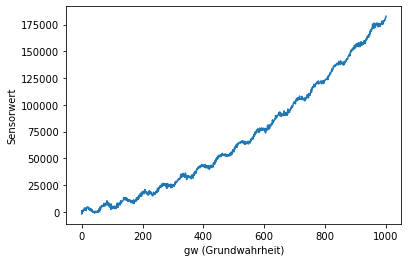

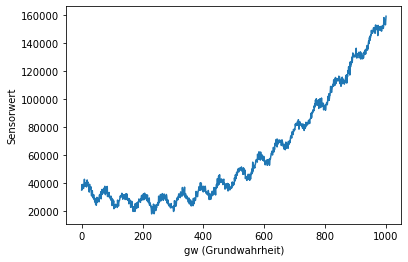

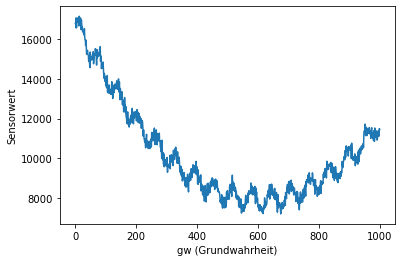

In [95]:
nr_sensors = 3
for sensor_nr in range(nr_sensors):
    bias = numpy.random.uniform(low=-100, high=100)
    var  = numpy.random.uniform(low=1, high=100)
    pos  = numpy.random.uniform(low=1, high=1000)
    fac  = numpy.random.uniform(low=1, high=100)
    s = sensor_strange_range(bias, var, pos, fac)
    s.zeige_sensor_kurve()

In [96]:
def erzeuge_sensoren(nr_sensors, diagrams=True):
    sensors = []
    for sensor_nr in range(nr_sensors):
        bias = numpy.random.uniform(low=-100, high=100)
        var  = numpy.random.uniform(low=1, high=100)
        pos  = numpy.random.uniform(low=1, high=1000)
        fac  = numpy.random.uniform(low=1, high=100)
        s = sensor_strange_range(bias, var, pos, fac)
        if diagrams:
            s.zeige_sensor_kurve()        
        sensors.append(s)
    return sensors

# Sensordatenfusion mit steigender Anzahl von Sensoren

In [97]:
def experiment(nr_sensors, diagrams=False):

    # 1. Erzeuge Sensoren
    sensors = erzeuge_sensoren(nr_sensors, diagrams)

    # 2. Beispieldaten fürs ML vorbereiten
    X = numpy.zeros( (1000,nr_sensors) )
    Y = numpy.zeros( (1000,1) )
    i = 0
    for e in range(0,1000):

        for sensor_nr, sensor in enumerate(sensors):
            sensorwert = sensor.get_sensorwert(e)
            X[i,sensor_nr] = sensorwert

        Y[i,0] = e    
        i += 1


    # 2. Beispieldaten in Trainings- und Testdaten aufteilen
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


    # 3. Skalierung der Trainings- und Testdaten
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled  = scaler.transform(x_test)


    # 4. k-NN Regressor erlernen
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
    knn = knn.fit(x_train_scaled, y_train)


    # 5. Modellgüte ermitteln
    y_pred_test = knn.predict( x_test_scaled )


    # 6. Plotten der Prädiktionen
    if diagrams:
        plt.scatter(y_test.flatten(), y_pred_test.flatten())
        plt.show()


    # 7. Quantitative Auswertung des mittleren Fehlers
    fehler = MAE( y_test.flatten(), y_pred_test.flatten() )
    print( f"nr_sensors={nr_sensors} -> MAE = {fehler:.2f}cm" )
    return fehler

In [98]:
ergebnisse_x = []
ergebnisse_y = []
for nr_sensors in range(2,11):
    
    alle_fehler = []
    for run in range(50):
        fehler = experiment(nr_sensors)
        alle_fehler.append(fehler)
        
    ergebnisse_x.append( nr_sensors )
    ergebnisse_y.append( numpy.mean(alle_fehler) )

nr_sensors=2 -> MAE = 10.61cm
nr_sensors=2 -> MAE = 9.61cm
nr_sensors=2 -> MAE = 28.41cm
nr_sensors=2 -> MAE = 5.93cm
nr_sensors=2 -> MAE = 7.89cm
nr_sensors=2 -> MAE = 18.55cm
nr_sensors=2 -> MAE = 8.08cm
nr_sensors=2 -> MAE = 5.47cm
nr_sensors=2 -> MAE = 11.97cm
nr_sensors=2 -> MAE = 12.51cm
nr_sensors=2 -> MAE = 15.19cm
nr_sensors=2 -> MAE = 10.34cm
nr_sensors=2 -> MAE = 14.12cm
nr_sensors=2 -> MAE = 72.19cm
nr_sensors=2 -> MAE = 30.52cm
nr_sensors=2 -> MAE = 7.45cm
nr_sensors=2 -> MAE = 5.86cm
nr_sensors=2 -> MAE = 5.33cm
nr_sensors=2 -> MAE = 13.26cm
nr_sensors=2 -> MAE = 7.87cm
nr_sensors=2 -> MAE = 5.13cm
nr_sensors=2 -> MAE = 13.87cm
nr_sensors=2 -> MAE = 18.18cm
nr_sensors=2 -> MAE = 9.53cm
nr_sensors=2 -> MAE = 4.57cm
nr_sensors=2 -> MAE = 7.47cm
nr_sensors=2 -> MAE = 4.51cm
nr_sensors=2 -> MAE = 11.87cm
nr_sensors=2 -> MAE = 10.18cm
nr_sensors=2 -> MAE = 14.64cm
nr_sensors=2 -> MAE = 26.10cm
nr_sensors=2 -> MAE = 7.26cm
nr_sensors=2 -> MAE = 9.08cm
nr_sensors=2 -> MAE = 13.2

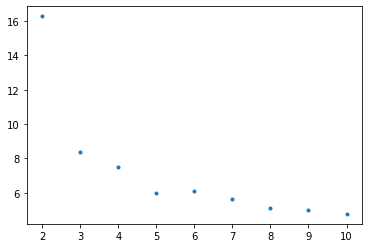

In [99]:
plt.scatter(ergebnisse_x, ergebnisse_y, marker=".")
plt.show()